## 关于数据集
这个数据集是由Cai-Nicolas Ziegler在2004年编辑的，它由三张表组成，供用户、书籍和评级。显式的评级是在1-10（更高的值表示更高的升值）和隐式评级的范围内表示的。

下载链接：http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip

数据集介绍：http://www2.informatik.uni-freiburg.de/~cziegler/BX/ 

## 本项目

这个项目需要基于用户和基于项目的协作过滤方法为用户构建一个图书推荐系统

In [83]:
#Making necessary imports
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation
from sklearn.metrics.pairwise import pairwise_distances
import ipywidgets as widgets
from IPython.display import display, clear_output
from contextlib import contextmanager
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os, sys
import re
import seaborn as sns

载入数据集

In [84]:
books = pd.read_csv('dataset/BX-Books.csv', sep=';',  on_bad_lines="skip", encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('dataset/BX-Users.csv', sep=';', on_bad_lines="skip", encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('dataset/BX-Book-Ratings.csv', sep=';', on_bad_lines="skip", encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

查看数据集大小

In [85]:
print (books.shape)
print (users.shape)
print (ratings.shape)

(271360, 8)
(278858, 3)
(1149780, 3)


## 书籍

探索书籍数据集

In [86]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


删除最后三列包含图像url的列，这将不需要进行分析

In [87]:
books.drop(['imageUrlS', 'imageUrlM', 'imageUrlL'],axis=1,inplace=True)

In [88]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [89]:
books.dtypes

ISBN                 object
bookTitle            object
bookAuthor           object
yearOfPublication    object
publisher            object
dtype: object

使这个设置在列中显示完整的文本

In [90]:
pd.set_option('display.max_colwidth', None)

### yearOfPublication

年刊应该设置为dtype为int，检查一年出版的独特价值。

从下面可以看出，在这个领域中有一些不正确的条目。

看起来像出版商名字的DK出版公司和'Gallimard'在数据集里被错误地加载了因为csv文件中的一些错误也有一些条目是字符串相同的年份在一些地方被输入为数字

In [91]:
books.yearOfPublication.unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

检查那些有“DK Publishing Inc”的行

In [92]:
books.loc[books.yearOfPublication == 'DK Publishing Inc',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


从上面可以看出，bookAuthor错误地装载了bookTitle，因此需要进行修正。

In [93]:
# ISBN '0789466953'
books.loc[books.ISBN == '0789466953','yearOfPublication'] = 2000
books.loc[books.ISBN == '0789466953','bookAuthor'] = "James Buckley"
books.loc[books.ISBN == '0789466953','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','bookTitle'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

In [94]:
#ISBN '078946697X'
books.loc[books.ISBN == '078946697X','yearOfPublication'] = 2000
books.loc[books.ISBN == '078946697X','bookAuthor'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','bookTitle'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

In [95]:
books.loc[(books.ISBN == '0789466953') | (books.ISBN == '078946697X'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)",Michael Teitelbaum,2000,DK Publishing Inc
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)",James Buckley,2000,DK Publishing Inc


修正完成

继续调查那些有“Gallimard”的文章

In [96]:
books.loc[books.yearOfPublication == 'Gallimard',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg


按照上面的要求进行修正，保持其他字段不变

In [97]:
books.loc[books.ISBN == '2070426769','yearOfPublication'] = 2003
books.loc[books.ISBN == '2070426769','bookAuthor'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
books.loc[books.ISBN == '2070426769','publisher'] = "Gallimard"
books.loc[books.ISBN == '2070426769','bookTitle'] = "Peuple du ciel, suivi de 'Les Bergers"

In [98]:
books.loc[books.ISBN == '2070426769',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard


修正完成

纠正出版年鉴的类型

In [99]:
books.yearOfPublication=pd.to_numeric(books.yearOfPublication, errors='coerce')

In [100]:
print (sorted(books['yearOfPublication'].unique()))

[np.int64(0), np.int64(1376), np.int64(1378), np.int64(1806), np.int64(1897), np.int64(1900), np.int64(1901), np.int64(1902), np.int64(1904), np.int64(1906), np.int64(1908), np.int64(1909), np.int64(1910), np.int64(1911), np.int64(1914), np.int64(1917), np.int64(1919), np.int64(1920), np.int64(1921), np.int64(1922), np.int64(1923), np.int64(1924), np.int64(1925), np.int64(1926), np.int64(1927), np.int64(1928), np.int64(1929), np.int64(1930), np.int64(1931), np.int64(1932), np.int64(1933), np.int64(1934), np.int64(1935), np.int64(1936), np.int64(1937), np.int64(1938), np.int64(1939), np.int64(1940), np.int64(1941), np.int64(1942), np.int64(1943), np.int64(1944), np.int64(1945), np.int64(1946), np.int64(1947), np.int64(1948), np.int64(1949), np.int64(1950), np.int64(1951), np.int64(1952), np.int64(1953), np.int64(1954), np.int64(1955), np.int64(1956), np.int64(1957), np.int64(1958), np.int64(1959), np.int64(1960), np.int64(1961), np.int64(1962), np.int64(1963), np.int64(1964), np.int64(1

现在我们可以看到，年鉴的所有值都是整数

然而，值0是无效的，当这个数据集于2004年发布时，我假设2006年之后的几年是无效的

在案例数据集被更新的情况下保留了一些保证金，将无效的年份设置为NaN在案例数据集被更新的情况下保留一定的空白

In [101]:
books.loc[(books.yearOfPublication > 2006) | (books.yearOfPublication == 0),'yearOfPublication'] = np.nan

用年出版的平均价值代替NaNs在案例数据集被更新的情况下保留一定的空白

In [102]:
books.yearOfPublication.fillna(round(books.yearOfPublication.mean()), inplace=True)

In [103]:
books.yearOfPublication.isnull().sum()

np.int64(0)

将dtype重置为int32

In [104]:
books.yearOfPublication = books.yearOfPublication.astype(np.int32)

### publisher

探索“publisher”列

In [105]:
books.loc[books.publisher.isnull(),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


调查有NaNs的行

以“Tyrant Moon”的书名来查看是否能得到任何线索

In [106]:
books.loc[(books.bookTitle == 'Tyrant Moon'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN


检查行是否有书签作为查找器，看看我们是否能得到任何线索

与不同的出版商和图书作者的所有行

In [107]:
books.loc[(books.bookTitle == 'Finders Keepers'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
10799,082177364X,Finders Keepers,Fern Michaels,2002,Zebra Books
42019,0070465037,Finders Keepers,Barbara Nickolae,1989,McGraw-Hill Companies
58264,0688118461,Finders Keepers,Emily Rodda,1993,Harpercollins Juvenile Books
66678,1575663236,Finders Keepers,Fern Michaels,1998,Kensington Publishing Corporation
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN
134309,0156309505,Finders Keepers,Will,1989,Voyager Books
173473,0973146907,Finders Keepers,Sean M. Costello,2002,Red Tower Publications
195885,0061083909,Finders Keepers,Sharon Sala,2003,HarperTorch
211874,0373261160,Finders Keepers,Elizabeth Travis,1993,Worldwide Library


由图书作者检查以找到模式

都有不同的出版商。这里没有线索

In [108]:
books.loc[(books.bookAuthor == 'Elaine Corvidae'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
126762,1931696934,Winter's Orphans,Elaine Corvidae,2001,Novelbooks
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129001,0759901880,Wolfkin,Elaine Corvidae,2001,Hard Shell Word Factory


由图书作者检查以找到模式

In [109]:
books.loc[(books.bookAuthor == 'Linnea Sinclair'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [110]:
#since there is nothing in common to infer publisher for NaNs, replacing these with 'other
books.loc[(books.ISBN == '193169656X'),'publisher'] = 'other'
books.loc[(books.ISBN == '1931696993'),'publisher'] = 'other'

## 用户

In [111]:
print (users.shape)
users.head()

(278858, 3)


,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [112]:
users.dtypes

userID        int64
Location     object
Age         float64
dtype: object

**userID**

In [113]:
users.userID.values

array([     1,      2,      3, ..., 278856, 278857, 278858])

我们可以看到这些都是独一无二的

**Age**

In [114]:
print (sorted(users.Age.unique()))

[np.float64(nan), np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0), np.float64(17.0), np.float64(18.0), np.float64(19.0), np.float64(20.0), np.float64(21.0), np.float64(22.0), np.float64(23.0), np.float64(24.0), np.float64(25.0), np.float64(26.0), np.float64(27.0), np.float64(28.0), np.float64(29.0), np.float64(30.0), np.float64(31.0), np.float64(32.0), np.float64(33.0), np.float64(34.0), np.float64(35.0), np.float64(36.0), np.float64(37.0), np.float64(38.0), np.float64(39.0), np.float64(40.0), np.float64(41.0), np.float64(42.0), np.float64(43.0), np.float64(44.0), np.float64(45.0), np.float64(46.0), np.float64(47.0), np.float64(48.0), np.float64(49.0), np.float64(50.0), np.float64(51.0), np.float64(52.0), np.float64(53.0), np.float64(54.0), np

年龄栏有一些无效的条目，比如nan，0和非常高的值，比如100和以上

在我看来，低于5和90以上的值对我们的图书评级案例没有多大意义。因此，用NaNs替换这些

In [115]:
users.loc[(users.Age > 90) | (users.Age < 5), 'Age'] = np.nan

用平均值代替NaNs

In [116]:
users.Age = users.Age.fillna(users.Age.mean())

将数据类型设置为int

In [117]:
users.Age = users.Age.astype(np.int32)

In [118]:
print (sorted(users.Age.unique()))

[np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31), np.int32(32), np.int32(33), np.int32(34), np.int32(35), np.int32(36), np.int32(37), np.int32(38), np.int32(39), np.int32(40), np.int32(41), np.int32(42), np.int32(43), np.int32(44), np.int32(45), np.int32(46), np.int32(47), np.int32(48), np.int32(49), np.int32(50), np.int32(51), np.int32(52), np.int32(53), np.int32(54), np.int32(55), np.int32(56), np.int32(57), np.int32(58), np.int32(59), np.int32(60), np.int32(61), np.int32(62), np.int32(63), np.int32(64), np.int32(65), np.int32(66), np.int32(67), np.int32(68), np.int32(69), np.int32(70), np.int32(71), np.int32(72), np.int32(73), np.int32(74), np.int32(75), np.int32(7

## 评级数据集

In [119]:
ratings.shape

(1149780, 3)

如果每个用户对每个条目进行评级，那么评级数据集将有nusers * nbooks条目，这表明数据集非常稀疏。

In [120]:
n_users = users.shape[0]
n_books = books.shape[0]
print (n_users * n_books)

75670906880


In [121]:
ratings.head(5)

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [122]:
ratings.bookRating.unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2])

除非将新书添加到图书数据集中，否则评级数据集应该只存在于我们的图书数据集里的书籍。

In [123]:
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]

In [124]:
print (ratings.shape)
print (ratings_new.shape)

(1149780, 3)
(1031136, 3)


可以看到，有许多行，有图书ISBN，而不是书籍数据集的一部分被删除了

除非新用户被添加到用户数据集，否则评级数据集应该有来自用户数据集的用户的评级。

In [125]:
ratings = ratings[ratings.userID.isin(users.userID)]

In [126]:
print (ratings.shape)
print (ratings_new.shape)

(1149780, 3)
(1031136, 3)


没有新用户添加，因此我们将使用高于数据集的新用户（1031136，3）

In [127]:
print ("number of users: " + str(n_users))
print ("number of books: " + str(n_books))

number of users: 278858
number of books: 271360


检查数据集的稀疏性

In [128]:
sparsity=1.0-len(ratings_new)/float(n_users*n_books)
print ('图书交叉数据集的稀疏级别是 ' +  str(sparsity*100) + ' %')

图书交叉数据集的稀疏级别是 99.99863734155898 %


正如在数据集的描述中所引用的

bx-图书评级包含图书评级信息。评级要么是明确的，以1-10的比例表示

更高的值表示更高的增值，或隐式，以0表示

In [129]:
ratings.bookRating.unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2])

因此，对隐式和显式的评级数据集进行了划分

In [130]:
ratings_explicit = ratings_new[ratings_new.bookRating != 0]
ratings_implicit = ratings_new[ratings_new.bookRating == 0]

In [131]:
print (ratings_new.shape)
print( ratings_explicit.shape)
print (ratings_implicit.shape)

(1031136, 3)
(383842, 3)
(647294, 3)


统计

更高的评级在用户中更常见，而评级8被评为最高次数

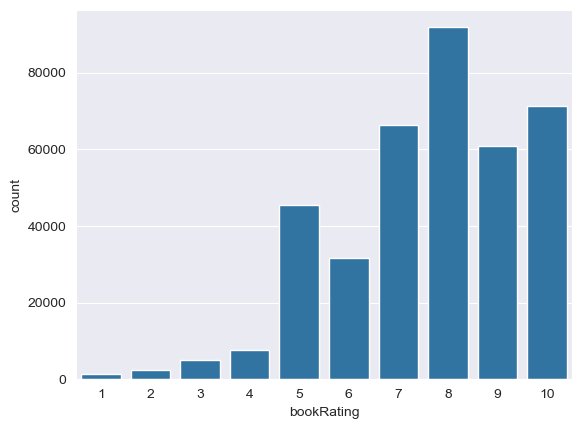

In [132]:
sns.countplot(data=ratings_explicit , x='bookRating')
plt.show()

## 基于简单流行度的推荐系统
在这一点上，可以基于不同书籍的用户评分来建立一个简单的基于流行的推荐系统。

以下是基于受欢迎程度的十大建议。

很明显 J. K. Rowling 写的书最受欢迎

In [133]:
ratings_count = pd.DataFrame(ratings_explicit.groupby(['ISBN'])['bookRating'].sum())
top10 = ratings_count.sort_values('bookRating', ascending = False).head(10)
print ("推荐下列书籍")
top10.merge(books, left_index = True, right_on = 'ISBN')

推荐下列书籍


,bookRating,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
408,5787,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
748,4108,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday
522,3134,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
2143,2798,059035342X,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999,Arthur A. Levine Books
356,2595,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
26,2551,0971880107,Wild Animus,Rich Shapero,2004,Too Far
1105,2524,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
706,2402,0446672211,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts,1998,Warner Books
231,2219,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books
118,2179,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star


类似地隔离那些在1-10中给出明确评分的用户以及那些隐含行为被跟踪的用户

In [134]:
users_exp_ratings = users[users.userID.isin(ratings_explicit.userID)]
users_imp_ratings = users[users.userID.isin(ratings_implicit.userID)]

In [135]:
print (users.shape)
print (users_exp_ratings.shape)
print (users_imp_ratings.shape)

(278858, 3)
(68091, 3)
(52451, 3)


## 基于协同过滤的推荐系统
为了更好地处理计算能力，并减少数据集的大小，我考虑的是那些至少有100本书的用户。以及至少有100个评分的书籍

In [136]:
counts1 = ratings_explicit['userID'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['userID'].isin(counts1[counts1 >= 100].index)]
counts = ratings_explicit['bookRating'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['bookRating'].isin(counts[counts >= 100].index)]

从显式的评级表生成评级矩阵

注意，大多数值都是NaN（未定义的），这意味着没有评级

In [137]:
ratings_matrix = ratings_explicit.pivot(index='userID', columns='ISBN', values='bookRating')
userID = ratings_matrix.index
ISBN = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.head()

(449, 66574)


ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,
2033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
n_users = ratings_matrix.shape[0] #只考虑那些给出明确评级的用户
n_books = ratings_matrix.shape[1]
print (n_users, n_books)

449 66574


因为NaNs不能通过训练算法来处理，将它们替换为0，这表示没有评级

设置数据类型

In [139]:
ratings_matrix.fillna(0, inplace = True)
ratings_matrix = ratings_matrix.astype(np.int32)

In [140]:
ratings_matrix.head(5)

ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,
2033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2276,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4017,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


复查稀疏

In [141]:
sparsity=1.0-len(ratings_explicit)/float(users_exp_ratings.shape[0]*n_books)
print ('图书交叉数据集的稀疏级别是 ' +  str(sparsity*100) + ' %')

图书交叉数据集的稀疏级别是 99.99772184106935 %


### 训练推荐系统
全局变量

In [142]:
global metric,k
k=10
metric='cosine'

### 1、基于用户的推荐系统

这个函数找到k个相似的用户，给定用户id和评级矩阵

这些相似点是通过使用配对距离获得的

In [143]:
def findksimilarusers(user_id, ratings, metric = metric, k=k):
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute') 
    model_knn.fit(ratings)
    loc = ratings.index.get_loc(user_id)
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
            
    return similarities,indices

这个函数根据基于用户的方法对指定的用户项组合进行评级

In [144]:
def predict_userbased(user_id, item_id, ratings, metric = metric, k=k):
    prediction=0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices=findksimilarusers(user_id, ratings,metric, k) #similar users based on cosine similarity
    mean_rating = ratings.iloc[user_loc,:].mean() #to adjust for zero based indexing
    sum_wt = np.sum(similarities)-1
    product=1
    wtd_sum = 0 
    
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == user_loc:
            continue;
        else: 
            ratings_diff = ratings.iloc[indices.flatten()[i],item_loc]-np.mean(ratings.iloc[indices.flatten()[i],:])
            product = ratings_diff * (similarities[i])
            wtd_sum = wtd_sum + product
    
    #在非常稀疏的数据集的情况下，使用基于协作的方法的相关度量可能会给出负面的评价
    #在这里的处理如下
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10
    
    prediction = int(round(mean_rating + (wtd_sum/sum_wt)))
    print ('用户预测等级 {0} -> item {1}: {2}'.format(user_id,item_id,prediction))

    return prediction

测试

In [145]:
predict_userbased(11676,'0001056107',ratings_matrix);

用户预测等级 11676 -> item 0001056107: 2


### 2、基于项目推荐系统
这个函数找到k个类似的项目，给定项目id和评级矩阵

In [146]:
def findksimilaritems(item_id, ratings, metric=metric, k=k):
    similarities=[]
    indices=[]
    ratings=ratings.T
    loc = ratings.index.get_loc(item_id)
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute')
    model_knn.fit(ratings)
    
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()

    return similarities,indices

In [147]:
similarities,indices=findksimilaritems('0001056107',ratings_matrix)

这个函数根据基于项目的方法预测特定用户项组合的评级

In [148]:
def predict_itembased(user_id, item_id, ratings, metric = metric, k=k):
    prediction= wtd_sum =0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices=findksimilaritems(item_id, ratings) #similar users based on correlation coefficients
    sum_wt = np.sum(similarities)-1
    product=1
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == item_loc:
            continue;
        else:
            product = ratings.iloc[user_loc,indices.flatten()[i]] * (similarities[i])
            wtd_sum = wtd_sum + product                              
    prediction = int(round(wtd_sum/sum_wt))
    
    #在非常稀疏的数据集的情况下，使用基于协作的方法的相关度量可能会给出负面的评价
    #在这里处理的是下面的//代码，没有下面的代码片段，下面的代码片段是为了避免负面影响
    #在使用相关度规时，可能会出现非常稀疏的数据集的预测
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10

    print ('用户预测等级 {0} -> item {1}: {2}'.format(user_id,item_id,prediction)    )  
    
    return prediction

测试

In [149]:
prediction = predict_itembased(11676,'0001056107',ratings_matrix)

用户预测等级 11676 -> item 0001056107: 1


**Thanks for reading this notebook**